In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ab-testing/ab_data.csv


# Import libraries

In [74]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
df = pd.read_csv("/kaggle/input/ab-testing/ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [76]:
df.shape[0]

294478

In [77]:
df.shape[1]

5

# **PART-1 PROBABILITY**

The number of unique users in the dataset.

In [78]:
df['user_id'].nunique()

290584

The proportion of users converted.

In [79]:
df.groupby('converted')['user_id'].nunique()[1]/df['user_id'].nunique()

0.12104245244060237

The number of times the new_page and treatment don't match.

In [80]:
df.loc[((df.group == "treatment") & (df.landing_page == "old_page")) | ((df.group == "control") & (df.landing_page == "new_page"))].shape[0]

3893

Missing values???

In [81]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

New dataset with control-oldpage & treatment-newpage

In [82]:
df2 = df.loc[((df.group=='control') & (df.landing_page=='old_page')) | ((df.group=='treatment') & (df.landing_page=='new_page')), :]

In [83]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [84]:
df2.shape[0]

290585

In [85]:
df2['user_id'].nunique()

290584

one row is repeated in df2

In [86]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


deleting this repeated user id

In [87]:
df2.drop(2893, axis=0, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


repeated row deleted

In [88]:
df2.shape[0]

290584

Probability of an individual converting regardless of the page they receive?

In [89]:
(df2["converted"].sum())/df2.shape[0]

0.11959708724499628

Given that an individual was in the control group, probability they converted?

In [90]:
df2[(df2.converted==1) & (df2.group=='control') ].shape[0]/df2[df2.group=='control'].shape[0]

0.1203863045004612

 Given that an individual was in the treatment group, probability they converted?

In [91]:
df2[(df2.converted==1) & (df2.group=='treatment') ].shape[0]/df2[df2.group=='treatment'].shape[0]

0.11880806551510564

probability that an individual received the new page?

In [92]:
df2[df2.landing_page=='new_page'].shape[0]/df2.shape[0]

0.5000619442226688

**Conclusion**-
1. About 12% of vistors are converted in all the cases - only control group, only treatment group or both combined 
2. The rate of conversion in control group is slightly higher than that of treatment group.
3. The effect of sample size doesn't play here as the amount of visitors landing on a new page or old page are almost 50%.

# PART-2 A/B TEST

### **Hypothesis** - Assuming that the old page is better unless the new page proves to be definitely better at an** error rate of 5%<br> Null Hypothesis: pold >= pnew<br> Alternative Hypothesis: pold < pnew


1. Assuming under the null hypothesis, pnew and pold both have "true" success rates equal to the converted success rate regardless of page - that is pnew and pold are equal. Furthermore, assuming they are equal to the converted rate in ab_data.csv regardless of the page.
2. Performing the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.

Conversion rate for pnew/pold (assumed that both are same) under the null hypothesis?

In [93]:
df2["converted"].sum() / df2.shape[0]

0.11959708724499628

Calculating nnew / nold, the number of individuals in the treatment/control group respectively

In [94]:
(df2.group).value_counts()

treatment    145310
control      145274
Name: group, dtype: int64

Simulating nnew transactions with a conversion rate of pnew under the null. Store these nnew 1's and 0's in new_page_converted.



In [95]:
pnew = df2["converted"].sum() / df2.shape[0]
nnew = df2.groupby('group')['user_id'].nunique()[1]

In [96]:
new_page_converted = np.random.choice(2, nnew, [1-pnew, pnew])

In [97]:
new_page_converted

array([0, 1, 1, ..., 1, 1, 1])

Simulating nold transactions with a conversion rate of pold under the null. Store these nold 1's and 0's in old_page_converted.


In [98]:
nold = df2.groupby('group')['user_id'].nunique()[0]
pold = df2.loc[df2.converted==1].shape[0]/df2.shape[0]

old_page_converted = np.random.choice(2, nold, [1-pold, pold])
old_page_converted

array([1, 0, 0, ..., 0, 1, 1])

In [99]:
new_page_converted.mean() - old_page_converted.mean()

-0.0010393111463987692

Creating 10,000 pnew-pold values using the same simulation process used above. Storing all 10,000 values in a NumPy array called p_diffs

In [101]:
p_diffs = []

In [103]:
for _ in range(10000):
    pnew_temp = np.random.choice(2, nnew, [1-pnew, pnew]).mean()
    pold_temp = np.random.choice(2, nold, [1-pold, pold]).mean()
    p_diffs.append(pnew_temp - pold_temp)

p_diffs = np.array(p_diffs)

Plot a histogram of the p_diffs.

In [105]:
control_converted = df2[(df2.converted==1) & (df2.group=='control') ].shape[0]/df2[df2.group=='control'].shape[0]
treatment_converted = df2[(df2.converted==1) & (df2.group=='treatment') ].shape[0]/df2[df2.group=='treatment'].shape[0]
actual_diff = treatment_converted - control_converted

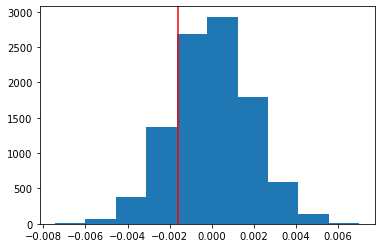

In [106]:
plt.hist(p_diffs)
plt.axvline(actual_diff,color='red')

Proportion of the p_diffs are greater than the actual difference observed in ab_data.csv

In [107]:
(p_diffs>actual_diff).mean()

0.8035

We have calculated the p-value - the probability of finding the given sample data provided we assume the null hypothesis (that pnew <= pnew). 
As the alternate hypothesis is p_new - p_pold > 0, we will be calculating the area in the right side of the graph above.

As p-value is very high (about 0.835), it means that there is not sufficient evidence to reject the null hypothesis.

## Using built-in features

In [109]:
import statsmodels.api as sm

convert_old = df2.loc[(df2.converted==1) & (df2.group=='control')].shape[0]
convert_new = df2.loc[(df2.converted==1) & (df2.group=='treatment')].shape[0]
nold = nold
nnew = nnew

Now using stats.proportions_ztest to compute  test statistic and p-value

In [110]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [nnew, nold], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


Since the absolute value of z-score 1.31092419842 is less than the critical value of 1.959963984540054 and the p-value is so high at 0.9, we can fail to reject the null hypotesis.

# PART-3 REGRESSION APPROACH

Since each row is either a conversion or no conversion, type of regression used is Logistic Regression - because it is a classification task

1. The goal is to use statsmodels to fit the regression model, to see if there is a significant difference in conversion based on which page a customer receives. 
2. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received. 
3. Adding an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [111]:
df2['intercept']=1
df2[['ab_page','old_page']]= pd.get_dummies(df2['landing_page'])
df2 = df2.drop('old_page', axis = 1)
df2.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [112]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [113]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        11:12:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with ab_page is 0.190. The null in c-e part is that there is no difference between the treatment and control group. Alternative hypotheses is that there is difference between between the treatment and control group

Part II assumes the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, compared to question c-e,they have different explainory varibale or factor for the result.

*There are many factors that might influence whether or not someone converts besides which landing page they hit. For example, whether or not they are in the target market, which may be identified by age, gender, or other demographic information, might directly influence whether or not someone buys. Of course, when adding additional terms into the regressional model it's important to consider that they are not correlated; for exmaple, we wouldn't want to add both interest in softball and gender because those are correlated.*